# comparison mb size 50 with 2, 4 cores in frequency minimum

In [6]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format

In [8]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [9]:
def add_label_column_df(df):
    for index, row in df.iterrows():
        _str = row["algorithm"]

        if "RUNPER" in _str and row["batch_size"] == 1:
            df.at[index, 'label'] = "Parallel"
        elif row["batch_size"] == 1:
            df.at[index, 'label'] = "Seq"
        else:
            df.at[index, 'label'] = row["batch_size"]
            
    return df

In [10]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [11]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [12]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [13]:
import natsort

#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']
    
    display(df)
    df.iloc[natsort.index_humansorted([df.label, df.batch_size])]

    labels = df.label
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x, pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [14]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(by=['batch_size']), alg)
           # df_aux = df_aux.sort_values(by=['label'], ascending=True)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Algorithm Methodology')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [15]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/mini-batching-medium/600/1200/first"
wantedCSVfilename = "data-batch-vs-acc-600-1200.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = add_label_column_df(df)
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

In [16]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/coletor-energia/mini-batching-mediumbatches/first/'

In [17]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [18]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

In [19]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [20]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                #print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [21]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [22]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

In [23]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, bsize, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

In [24]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [25]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [26]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15
    alg_order = ['B25', 'B50', 'B75', 'B100']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 4
    for i in range(versions):
        adf = df.iloc[i]
        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [27]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#             display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
       
        # debug print, if it shows it is wrong
        # if len(showdf) != 5:
        #     display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [28]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']

    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        display(dsdf)
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=3, bbox_to_anchor=(0.9, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

In [29]:
def read_data_create_final_dataframe(freq, DEBUG=True):
    d = {}
    global header_printed
    header_printed = False
    if freq['cores'] != None:
        folder_path = f"{PATH_TO_RESULTS}{freq['cores']}/{freq['minimum']}/{freq['maximum']}"
    else:
        folder_path = f"{PATH_TO_RESULTS}{freq['minimum']}/{freq['maximum']}"
    min = freq['minimum']
    max = freq['maximum']
    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}tdf-{min}x{max}.csv")    
    return tdf

In [30]:
freqs = [{'minimum': '600', 'maximum': '1200', 'cores': None}]
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

moaDF: 288    mdf: 288     sshDF: 288


In [31]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df




----------------- {'minimum': '600', 'maximum': '1200', 'cores': None} -----------------


,algorithm,dataset,cores,batch_size,inc_rate,out_rate,instances,time,delay,acc,...,avg_measure,sum_measure,prod_rate,tt_inst_prod,avg_times_duration,joules,JPIold,JPI,PERC,tput
49,StreamingRandomPatches,airlines,4,100,164,71.32,"8,600.00",120.58,"1,399.00",65.31,...,6.24,"1,404.20",159.73,"19,168.00",773.87,752.55,0.00,0.09,90,71.32
70,StreamingRandomPatches,airlines,4,100,91,71.68,"8,700.00",121.37,"1,388.00",65.47,...,6.13,"1,398.40",89.86,"10,800.00",772.80,744.38,0.00,0.09,50,71.68
195,StreamingRandomPatches,airlines,4,100,18,14.79,"1,800.00",121.69,"4,387.00",75.12,...,4.17,959.20,14.98,"1,800.00",525.47,507.50,0.00,0.29,10,14.79
187,StreamingRandomPatches,airlines,4,75,156,68.94,"8,325.00",120.76,"1,086.00",65.94,...,6.17,"1,400.30",154.74,"18,600.00",771.09,744.95,0.00,0.09,90,68.94
143,StreamingRandomPatches,airlines,4,75,86,68.09,"8,175.00",120.07,"1,097.00",65.56,...,6.06,"1,362.70",84.87,"10,200.00",751.00,727.17,0.00,0.09,50,68.09
163,StreamingRandomPatches,airlines,4,75,17,14.82,"1,800.00",121.44,"3,229.00",75.19,...,4.01,909.20,14.98,"1,800.00",500.66,486.42,0.00,0.28,10,14.82
94,StreamingRandomPatches,airlines,4,50,156,68.60,"8,250.00",120.27,728.00,65.52,...,6.07,"1,359.80",154.73,"18,569.00",752.75,730.10,0.00,0.09,90,68.60
203,StreamingRandomPatches,airlines,4,50,87,69.42,"8,350.00",120.28,718.00,65.61,...,6.04,"1,377.50",84.87,"10,200.00",755.21,726.70,0.00,0.09,50,69.42
207,StreamingRandomPatches,airlines,4,50,17,14.88,"1,800.00",120.98,"2,172.00",75.49,...,4.15,937.40,14.98,"1,800.00",518.47,501.82,0.00,0.29,10,14.88
170,StreamingRandomPatches,airlines,4,25,153,69.97,"8,425.00",120.40,357.00,65.64,...,6.09,"1,383.50",149.75,"17,970.00",761.84,733.83,0.00,0.09,90,69.97


,algorithm,dataset,cores,batch_size,inc_rate,out_rate,instances,time,delay,acc,...,avg_measure,sum_measure,prod_rate,tt_inst_prod,avg_times_duration,joules,JPIold,JPI,PERC,tput
5,StreamingRandomPatches,GMSC,4,100,615,613.20,"73,600.00",120.03,151.00,93.49,...,5.52,"1,246.60",613.37,"73,677.00",683.98,662.06,0.00,0.01,90,613.20
96,StreamingRandomPatches,GMSC,4,100,342,339.46,"40,732.00",119.99,221.00,93.48,...,4.63,"1,037.10",339.26,"40,732.00",574.11,555.54,0.00,0.01,50,339.46
222,StreamingRandomPatches,GMSC,4,100,68,64.94,"7,800.00",120.11,903.00,93.60,...,3.91,882.70,64.90,"7,800.00",484.31,469.10,0.00,0.06,10,64.94
190,StreamingRandomPatches,GMSC,4,75,592,588.08,"70,575.00",120.01,117.00,93.43,...,5.50,"1,237.80",588.46,"70,682.00",682.17,660.22,0.00,0.01,90,588.08
85,StreamingRandomPatches,GMSC,4,75,329,324.26,"38,925.00",120.04,166.00,93.51,...,4.60,"1,035.60",324.32,"38,935.00",570.73,552.52,0.00,0.01,50,324.26
147,StreamingRandomPatches,GMSC,4,75,65,64.95,"7,800.00",120.09,684.00,93.67,...,3.98,895.90,64.90,"7,800.00",493.74,478.17,0.00,0.06,10,64.95
36,StreamingRandomPatches,GMSC,4,50,572,568.60,"68,250.00",120.03,79.00,93.43,...,5.45,"1,230.80",568.56,"68,286.00",680.75,653.70,0.00,0.01,90,568.60
215,StreamingRandomPatches,GMSC,4,50,317,314.69,"37,737.00",119.92,116.00,93.49,...,4.60,"1,040.30",314.34,"37,737.00",570.78,551.99,0.00,0.02,50,314.69
198,StreamingRandomPatches,GMSC,4,50,63,59.98,"7,200.00",120.05,475.00,93.65,...,3.86,861.50,59.91,"7,200.00",475.18,463.78,0.00,0.07,10,59.98
84,StreamingRandomPatches,GMSC,4,25,605,603.29,"72,400.00",120.01,38.00,93.40,...,5.44,"1,223.40",603.39,"72,479.00",674.23,652.52,0.00,0.01,90,603.29


,algorithm,dataset,cores,batch_size,inc_rate,out_rate,instances,time,delay,acc,...,avg_measure,sum_measure,prod_rate,tt_inst_prod,avg_times_duration,joules,JPIold,JPI,PERC,tput
42,StreamingRandomPatches,elecNormNew,4,100,365,363.90,"43,700.00",120.09,262.00,79.90,...,5.89,"1,325.90",364.14,"43,727.00",730.72,707.67,0.00,0.02,90,363.90
106,StreamingRandomPatches,elecNormNew,4,100,203,199.92,"23,960.00",119.85,380.00,80.97,...,4.94,"1,111.40",199.62,"23,960.00",612.50,591.99,0.00,0.03,50,199.92
277,StreamingRandomPatches,elecNormNew,4,100,40,39.95,"4,800.00",120.14,"1,445.00",80.66,...,4.09,920.60,39.94,"4,800.00",507.35,491.55,0.00,0.11,10,39.95
117,StreamingRandomPatches,elecNormNew,4,75,352,349.37,"41,925.00",120.00,194.00,79.98,...,5.70,"1,289.30",349.17,"41,930.00",713.11,684.59,0.00,0.02,90,349.37
138,StreamingRandomPatches,elecNormNew,4,75,195,194.36,"23,325.00",120.01,310.00,81.93,...,4.84,"1,084.50",194.63,"23,361.00",595.51,581.03,0.00,0.03,50,194.36
56,StreamingRandomPatches,elecNormNew,4,75,39,34.97,"4,200.00",120.10,"1,231.00",80.97,...,3.99,894.20,34.95,"4,200.00",495.00,479.43,0.00,0.12,10,34.97
31,StreamingRandomPatches,elecNormNew,4,50,351,349.55,"41,930.00",119.95,131.00,80.95,...,5.87,"1,332.00",349.19,"41,930.00",733.48,703.87,0.00,0.02,90,349.55
141,StreamingRandomPatches,elecNormNew,4,50,195,194.80,"23,361.00",119.92,196.00,82.61,...,4.86,"1,093.70",194.62,"23,361.00",602.75,582.93,0.00,0.03,50,194.80
8,StreamingRandomPatches,elecNormNew,4,50,39,34.99,"4,200.00",120.04,820.00,82.48,...,3.83,854.80,34.95,"4,200.00",471.48,460.15,0.00,0.11,10,34.99
98,StreamingRandomPatches,elecNormNew,4,25,332,329.31,"39,525.00",120.02,68.00,82.23,...,5.58,"1,265.90",329.21,"39,534.00",697.08,669.33,0.00,0.02,90,329.31


,algorithm,dataset,cores,batch_size,inc_rate,out_rate,instances,time,delay,acc,...,avg_measure,sum_measure,prod_rate,tt_inst_prod,avg_times_duration,joules,JPIold,JPI,PERC,tput
286,StreamingRandomPatches,covtypeNorm,4,100,125,124.97,"14,975.00",119.82,712.00,71.77,...,5.23,"1,182.20",124.78,"14,975.00",653.87,626.80,0.00,0.04,90,124.97
281,StreamingRandomPatches,covtypeNorm,4,100,69,64.77,"7,800.00",120.42,"1,170.00",73.31,...,4.47,"1,020.00",64.90,"7,800.00",559.21,538.73,0.00,0.07,50,64.77
17,StreamingRandomPatches,covtypeNorm,4,100,13,9.97,"1,200.00",120.39,"5,726.00",62.73,...,3.78,853.50,9.99,"1,200.00",472.07,454.65,0.00,0.39,10,9.97
172,StreamingRandomPatches,covtypeNorm,4,75,135,134.92,"16,173.00",119.87,521.00,73.79,...,5.28,"1,140.90",134.76,"16,173.00",654.96,633.17,0.00,0.04,90,134.92
144,StreamingRandomPatches,covtypeNorm,4,75,75,74.61,"9,000.00",120.63,744.00,75.32,...,4.06,920.90,74.88,"9,000.00",507.10,489.39,0.00,0.06,50,74.61
15,StreamingRandomPatches,covtypeNorm,4,75,15,14.97,"1,800.00",120.21,"2,879.00",67.25,...,4.19,947.10,14.98,"1,800.00",523.84,503.76,0.00,0.29,10,14.97
32,StreamingRandomPatches,covtypeNorm,4,50,126,124.85,"14,975.00",119.94,338.00,75.44,...,5.24,"1,194.40",124.79,"14,975.00",654.82,628.32,0.00,0.04,90,124.85
44,StreamingRandomPatches,covtypeNorm,4,50,70,69.89,"8,387.00",120.00,552.00,76.89,...,4.42,959.40,69.89,"8,400.00",543.81,530.56,0.00,0.06,50,69.89
62,StreamingRandomPatches,covtypeNorm,4,50,14,9.98,"1,200.00",120.19,"2,783.00",66.87,...,4.06,926.00,9.99,"1,200.00",507.68,488.12,0.00,0.42,10,9.98
237,StreamingRandomPatches,covtypeNorm,4,25,114,109.74,"13,175.00",120.05,191.00,77.98,...,5.15,"1,159.60",109.81,"13,178.00",639.07,618.72,0.00,0.05,90,109.74


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


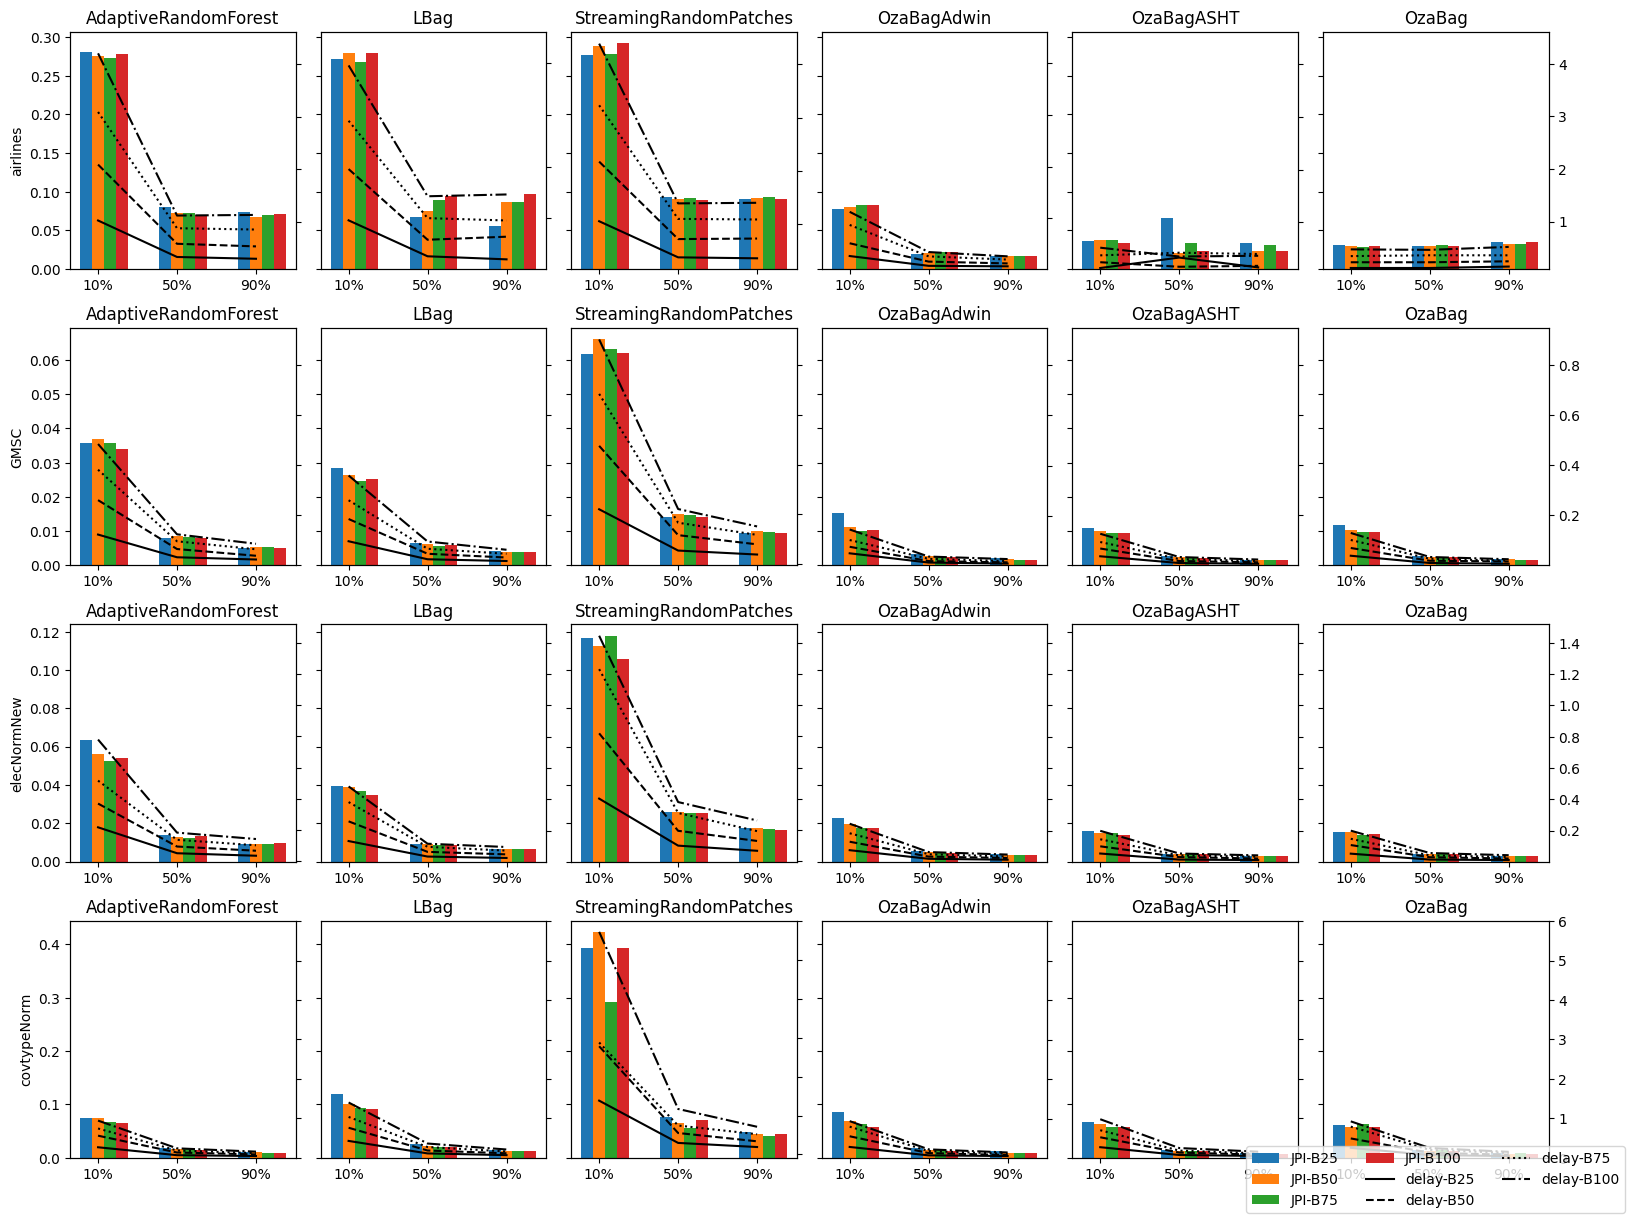

In [32]:
for f,df in zip(freqs, dataframes):
    print(f'\n\n\n----------------- {f} -----------------')
    df = select_columns_and_rename_values_basic(df)
    gen_graph(df, bars=True, freq=f"{f['minimum']}x{f['maximum']}")

In [33]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/coletor-energia/dpm/first/'

In [49]:
freqs = [
    {'minimum': '600', 'maximum': '600', 'cores': 2}, 
    {'minimum': '1200', 'maximum': '1200', 'cores': 2},
    {'minimum': '600', 'maximum': '600', 'cores': 4},
    {'minimum': '1200', 'maximum': '1200', 'cores': 4},
]

# mergear o 0 com o 2 -> 600x600 2 cores e 600x600 4 cores
# mergear o 1 com o 3 -> 1200x1200 2 cores e 1200x1200 4 cores

dataaframes_dvfs = []
for f in freqs:
    dataaframes_dvfs.append(read_data_create_final_dataframe(f, True))
    
dataframes_minimum_freq = pd.merge(dataaframes_dvfs[0], dataaframes_dvfs[2], how = 'outer')
dataframes_maximum_freq = pd.merge(dataaframes_dvfs[1], dataaframes_dvfs[3], how = 'outer')

df = dataframes[0]
df = df.drop(df[df.batch_size == 25].index)
df = df.drop(df[df.batch_size == 75].index)
df = df.drop(df[df.batch_size == 100].index)

dataframes_minimum_freq_mb = pd.merge(dataframes_minimum_freq, df, how = 'outer')
dataframes_maximum_freq_mb = pd.merge(dataframes_maximum_freq, df, how = 'outer')

moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144


In [50]:
def build_label(df):
    for index, row in df.iterrows():
        if (row['algorithm'].find('RUNPER') and row['cores'] == 2):
            df.at[index, 'label'] = "PLR-2"

        if (row['algorithm'].find('RUNPER') and row['cores'] == 4):
            df.at[index, 'label'] = "PLR-4"

        if (row['algorithm'].find('Sequential') and row['cores'] == 1):
            df.at[index, 'label'] = "SEQ"

        if (row['batch_size'] == 50):
            df.at[index, 'label'] = "MB"
            
    return df

In [51]:
def gen_graph_joules(df, execution='first', only_eficiency=False):
    filename = f"pi-rates"
    fig, axs = plt.subplots(4, 6, figsize=(16,12))
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']

    for ds in datasets:
        current_df = df[(df.dataset == ds)]
        my_id_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:
            dfalg = filter_by_substring_algorithm(current_df, alg)
            display(dfalg)
            dfalg = dfalg.iloc[:-1 , :] # remove duplicidade sequencial
            my_id = algorithms.index(alg)
            c1 = 'tab:red'
            c2 = 'tab:blue'
            c3 = 'tab:green'
            labels = dfalg.label
            x = np.arange(len(labels))
            alg_order = algorithms.index(alg)
            
            ax = axs[int(my_id_ds)][my_id%6]
            ax.plot(x, pd.to_numeric(dfalg.JPI), color=c1, linewidth=0.75, label='JPI')
            ax.tick_params(axis='y', labelcolor=c1)

            ax2 = ax.twinx()
            ax2.plot(x, pd.to_numeric(dfalg.IPS), color=c2, linewidth=0.7, label='IPS')
            ax2.tick_params(axis='y', labelcolor=c2)
            
            ax.set_title(f'{alg}')
            
            #if its the first column, print Y-axis label
            if my_id%6 == 0:
                ax.set_ylabel(f'{ds}')

            #if its the last row, print the X-axis label
            if int(my_id/6) == 1:
                ax.set_xlabel('Cores')

            ax.set_xticks(x)
            ax.set_xticklabels(labels)

            ax.legend(loc='upper center', bbox_to_anchor=(0, -0.20), fancybox=True, shadow=True, ncol=5)
            ax2.legend(loc='upper center', bbox_to_anchor=(0.90, -0.20), fancybox=True, shadow=True, ncol=5)

    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
#     lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
#     plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')




----------------- {'minimum': '1200', 'maximum': '1200', 'cores': 4} -----------------


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
339,airlines,ARF,50,65.95,"11,250.00",120.20,0.07,4,93.59,MB
105,airlines,ARFRUNPER,1,71.60,"2,968.00",120.01,0.15,2,24.73,PLR-2
249,airlines,ARFRUNPER,1,69.15,"4,149.00",120.01,0.12,4,34.57,PLR-4
102,airlines,ARFSequential,1,72.63,"2,232.00",120.07,0.20,1,18.59,SEQ
246,airlines,ARFSequential,1,72.45,"2,301.00",120.01,0.19,1,19.17,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
336,airlines,LBag,50,61.81,"9,300.00",120.34,0.09,4,77.28,MB
99,airlines,LBagRUNPER,1,69.16,"3,560.00",120.01,0.13,2,29.66,PLR-2
243,airlines,LBagRUNPER,1,66.20,"4,731.00",120.03,0.11,4,39.42,PLR-4
96,airlines,LBagSequential,1,70.40,"2,797.00",120.06,0.16,1,23.30,SEQ
240,airlines,LBagSequential,1,70.29,"2,898.00",120.04,0.16,1,24.14,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
324,airlines,SRPSequential,50,65.52,"8,250.00",120.27,0.09,4,68.60,MB
72,airlines,SRPRUNPER,1,74.06,"2,325.00",120.03,0.19,2,19.37,PLR-2
216,airlines,SRPRUNPER,1,71.78,"3,349.00",120.01,0.14,4,27.91,PLR-4
75,airlines,SRPSequential,1,74.35,"1,692.00",120.03,0.25,1,14.10,SEQ
219,airlines,SRPSequential,1,74.35,"1,739.00",120.02,0.25,1,14.49,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
330,airlines,OBAdwinSequential,50,68.65,"46,150.00",120.06,0.02,4,384.40,MB
81,airlines,OBAdwinRUNPER,1,65.21,"7,631.00",120.00,0.06,2,63.59,PLR-2
225,airlines,OBAdwinRUNPER,1,64.30,"9,687.00",120.05,0.05,4,80.69,PLR-4
84,airlines,OBAdwinSequential,1,64.63,"8,397.00",120.07,0.05,1,69.93,SEQ
228,airlines,OBAdwinSequential,1,64.36,"8,804.00",120.01,0.05,1,73.36,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
333,airlines,OBASHTSequential,50,67.76,"34,300.00",121.91,0.02,4,281.36,MB
87,airlines,OBASHTRUNPER,1,66.16,"5,800.00",120.00,0.08,2,48.33,PLR-2
231,airlines,OBASHTRUNPER,1,63.43,"9,746.00",120.03,0.05,4,81.20,PLR-4
90,airlines,OBASHTSequential,1,64.57,"8,549.00",120.08,0.05,1,71.19,SEQ
234,airlines,OBASHTSequential,1,64.13,"8,843.00",120.02,0.05,1,73.68,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
327,airlines,OBSequential,50,66.19,"24,700.00",120.98,0.03,4,204.16,MB
78,airlines,OBRUNPER,1,63.90,"7,474.00",120.06,0.06,2,62.25,PLR-2
222,airlines,OBRUNPER,1,63.14,"10,025.00",120.01,0.05,4,83.53,PLR-4
93,airlines,OBSequential,1,64.36,"8,827.00",120.06,0.05,1,73.52,SEQ
237,airlines,OBSequential,1,64.74,"8,734.00",120.00,0.05,1,72.78,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
357,GMSC,ARF,50,93.53,"119,600.00",119.96,0.01,4,996.97,MB
141,GMSC,ARFRUNPER,1,93.46,"33,392.00",120.00,0.01,2,278.26,PLR-2
285,GMSC,ARFRUNPER,1,93.46,"34,143.00",119.99,0.01,4,284.54,PLR-4
282,GMSC,ARFSequential,1,93.52,"31,278.00",120.00,0.01,1,260.65,SEQ
138,GMSC,ARFSequential,1,93.52,"31,778.00",120.00,0.01,1,264.81,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
354,GMSC,LBag,50,93.34,"150,000.00",107.18,0.00,4,"1,399.55",MB
135,GMSC,LBagRUNPER,1,93.37,"41,746.00",120.01,0.01,2,347.86,PLR-2
279,GMSC,LBagRUNPER,1,93.39,"43,701.00",120.00,0.01,4,364.17,PLR-4
276,GMSC,LBagSequential,1,93.37,"42,215.00",120.00,0.01,1,351.79,SEQ
132,GMSC,LBagSequential,1,93.42,"40,198.00",120.00,0.01,1,334.98,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
342,GMSC,SRPSequential,50,93.43,"68,250.00",120.03,0.01,4,568.60,MB
108,GMSC,SRPRUNPER,1,93.58,"18,570.00",120.01,0.02,2,154.74,PLR-2
252,GMSC,SRPRUNPER,1,93.58,"18,569.00",119.94,0.02,4,154.81,PLR-4
255,GMSC,SRPSequential,1,93.61,"18,057.00",120.01,0.02,1,150.46,SEQ
111,GMSC,SRPSequential,1,93.57,"16,883.00",120.00,0.03,1,140.69,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
348,GMSC,OBAdwinSequential,50,93.33,"149,259.00",45.95,0.00,4,"3,248.01",MB
117,GMSC,OBAdwinRUNPER,1,93.48,"76,664.00",120.00,0.01,2,638.86,PLR-2
261,GMSC,OBAdwinRUNPER,1,93.45,"77,812.00",120.00,0.01,4,648.43,PLR-4
120,GMSC,OBAdwinSequential,1,93.38,"77,789.00",120.00,0.01,1,648.24,SEQ
264,GMSC,OBAdwinSequential,1,93.38,"77,785.00",120.00,0.01,1,648.20,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
351,GMSC,OBASHTSequential,50,93.36,"150,000.00",41.10,0.00,4,"3,649.90",MB
123,GMSC,OBASHTRUNPER,1,93.41,"92,628.00",120.01,0.00,2,771.84,PLR-2
267,GMSC,OBASHTRUNPER,1,93.41,"95,681.00",120.00,0.00,4,797.34,PLR-4
270,GMSC,OBASHTSequential,1,93.36,"95,681.00",120.01,0.00,1,797.27,SEQ
126,GMSC,OBASHTSequential,1,93.38,"95,528.00",120.00,0.00,1,796.06,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
345,GMSC,OBSequential,50,93.39,"149,625.00",49.43,0.00,4,"3,027.19",MB
114,GMSC,OBRUNPER,1,93.44,"71,929.00",120.01,0.01,2,599.38,PLR-2
258,GMSC,OBRUNPER,1,93.49,"93,895.00",120.00,0.00,4,782.45,PLR-4
273,GMSC,OBSequential,1,93.45,"93,899.00",120.00,0.00,1,782.49,SEQ
129,GMSC,OBSequential,1,93.45,"93,887.00",120.00,0.00,1,782.38,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
303,elecNormNew,ARF,50,80.72,"43,654.00",65.86,0.01,4,662.88,MB
33,elecNormNew,ARFRUNPER,1,89.74,"19,945.00",120.00,0.02,2,166.21,PLR-2
177,elecNormNew,ARFRUNPER,1,89.58,"21,564.00",119.95,0.02,4,179.78,PLR-4
30,elecNormNew,ARFSequential,1,89.40,"15,653.00",120.08,0.03,1,130.36,SEQ
174,elecNormNew,ARFSequential,1,89.50,"16,318.00",120.00,0.03,1,135.98,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
300,elecNormNew,LBag,50,81.39,"42,962.00",44.80,0.01,4,958.91,MB
27,elecNormNew,LBagRUNPER,1,89.61,"32,220.00",120.01,0.01,2,268.48,PLR-2
171,elecNormNew,LBagRUNPER,1,89.91,"32,945.00",119.97,0.01,4,274.60,PLR-4
24,elecNormNew,LBagSequential,1,89.90,"29,573.00",120.00,0.02,1,246.44,SEQ
168,elecNormNew,LBagSequential,1,90.01,"29,297.00",120.01,0.02,1,244.13,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
288,elecNormNew,SRPSequential,50,80.95,"41,930.00",119.95,0.02,4,349.55,MB
0,elecNormNew,SRPRUNPER,1,91.50,"11,382.00",120.01,0.04,2,94.84,PLR-2
144,elecNormNew,SRPRUNPER,1,91.50,"11,382.00",120.01,0.04,4,94.84,PLR-4
3,elecNormNew,SRPSequential,1,91.68,"10,806.00",120.00,0.04,1,90.05,SEQ
147,elecNormNew,SRPSequential,1,91.67,"11,143.00",120.00,0.04,1,92.86,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
294,elecNormNew,OBAdwinSequential,50,79.48,"42,484.00",23.52,0.00,4,"1,806.45",MB
9,elecNormNew,OBAdwinRUNPER,1,85.88,"42,813.00",103.17,0.01,2,414.97,PLR-2
153,elecNormNew,OBAdwinRUNPER,1,86.13,"45,238.00",103.18,0.01,4,438.42,PLR-4
12,elecNormNew,OBAdwinSequential,1,84.79,"45,153.00",103.17,0.01,1,437.65,SEQ
156,elecNormNew,OBAdwinSequential,1,84.77,"45,312.00",103.17,0.01,1,439.21,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
297,elecNormNew,OBASHTSequential,50,79.37,"43,758.00",19.06,0.00,4,"2,295.92",MB
15,elecNormNew,OBASHTRUNPER,1,83.99,"41,844.00",81.87,0.01,2,511.11,PLR-2
159,elecNormNew,OBASHTRUNPER,1,82.97,"44,786.00",81.86,0.01,4,547.07,PLR-4
18,elecNormNew,OBASHTSequential,1,82.55,"43,900.00",81.86,0.01,1,536.30,SEQ
162,elecNormNew,OBASHTSequential,1,83.39,"45,231.00",81.86,0.01,1,552.51,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
291,elecNormNew,OBSequential,50,78.67,"43,510.00",19.58,0.00,4,"2,222.73",MB
6,elecNormNew,OBRUNPER,1,83.03,"42,000.00",79.03,0.01,2,531.42,PLR-2
150,elecNormNew,OBRUNPER,1,82.39,"44,950.00",79.05,0.01,4,568.62,PLR-4
21,elecNormNew,OBSequential,1,82.70,"44,139.00",79.03,0.01,1,558.48,SEQ
165,elecNormNew,OBSequential,1,82.72,"45,286.00",79.04,0.01,1,572.94,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
321,covtypeNorm,ARF,50,86.23,"62,100.00",120.05,0.01,4,517.28,MB
69,covtypeNorm,ARFRUNPER,1,73.67,"12,864.00",120.02,0.03,2,107.18,PLR-2
213,covtypeNorm,ARFRUNPER,1,75.95,"17,481.00",119.93,0.03,4,145.76,PLR-4
66,covtypeNorm,ARFSequential,1,74.75,"10,916.00",120.00,0.04,1,90.96,SEQ
210,covtypeNorm,ARFSequential,1,75.92,"10,973.00",120.00,0.04,1,91.44,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
318,covtypeNorm,LBag,50,85.43,"47,900.00",120.02,0.01,4,399.11,MB
63,covtypeNorm,LBagRUNPER,1,73.21,"9,413.00",120.04,0.05,2,78.42,PLR-2
207,covtypeNorm,LBagRUNPER,1,74.62,"12,283.00",120.01,0.04,4,102.35,PLR-4
60,covtypeNorm,LBagSequential,1,73.46,"8,135.00",120.00,0.05,1,67.79,SEQ
204,covtypeNorm,LBagSequential,1,72.42,"7,655.00",120.04,0.06,1,63.77,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
306,covtypeNorm,SRPSequential,50,75.44,"14,975.00",119.94,0.04,4,124.85,MB
36,covtypeNorm,SRPRUNPER,1,82.40,"5,382.00",120.00,0.08,2,44.85,PLR-2
180,covtypeNorm,SRPRUNPER,1,82.37,"5,383.00",120.00,0.08,4,44.86,PLR-4
39,covtypeNorm,SRPSequential,1,82.93,"4,697.00",120.01,0.09,1,39.14,SEQ
183,covtypeNorm,SRPSequential,1,82.91,"4,997.00",120.03,0.09,1,41.63,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
312,covtypeNorm,OBAdwinSequential,50,83.41,"66,150.00",120.01,0.01,4,551.19,MB
45,covtypeNorm,OBAdwinRUNPER,1,74.62,"9,646.00",120.01,0.05,2,80.38,PLR-2
189,covtypeNorm,OBAdwinRUNPER,1,74.32,"13,063.00",120.00,0.04,4,108.86,PLR-4
48,covtypeNorm,OBAdwinSequential,1,70.65,"10,670.00",120.00,0.04,1,88.91,SEQ
192,covtypeNorm,OBAdwinSequential,1,70.31,"10,835.00",120.03,0.04,1,90.27,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
315,covtypeNorm,OBASHTSequential,50,81.67,"74,350.00",120.01,0.01,4,619.54,MB
51,covtypeNorm,OBASHTRUNPER,1,64.58,"12,542.00",120.00,0.04,2,104.51,PLR-2
195,covtypeNorm,OBASHTRUNPER,1,64.62,"12,579.00",119.93,0.04,4,104.88,PLR-4
54,covtypeNorm,OBASHTSequential,1,64.53,"12,289.00",120.01,0.04,1,102.40,SEQ
198,covtypeNorm,OBASHTSequential,1,64.60,"12,247.00",120.00,0.04,1,102.06,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
309,covtypeNorm,OBSequential,50,81.89,"77,200.00",120.03,0.01,4,643.20,MB
42,covtypeNorm,OBRUNPER,1,64.89,"13,826.00",120.01,0.03,2,115.21,PLR-2
186,covtypeNorm,OBRUNPER,1,66.27,"15,727.00",120.00,0.03,4,131.06,PLR-4
57,covtypeNorm,OBSequential,1,65.51,"15,749.00",120.00,0.03,1,131.24,SEQ
201,covtypeNorm,OBSequential,1,65.17,"15,449.00",120.00,0.03,1,128.74,SEQ


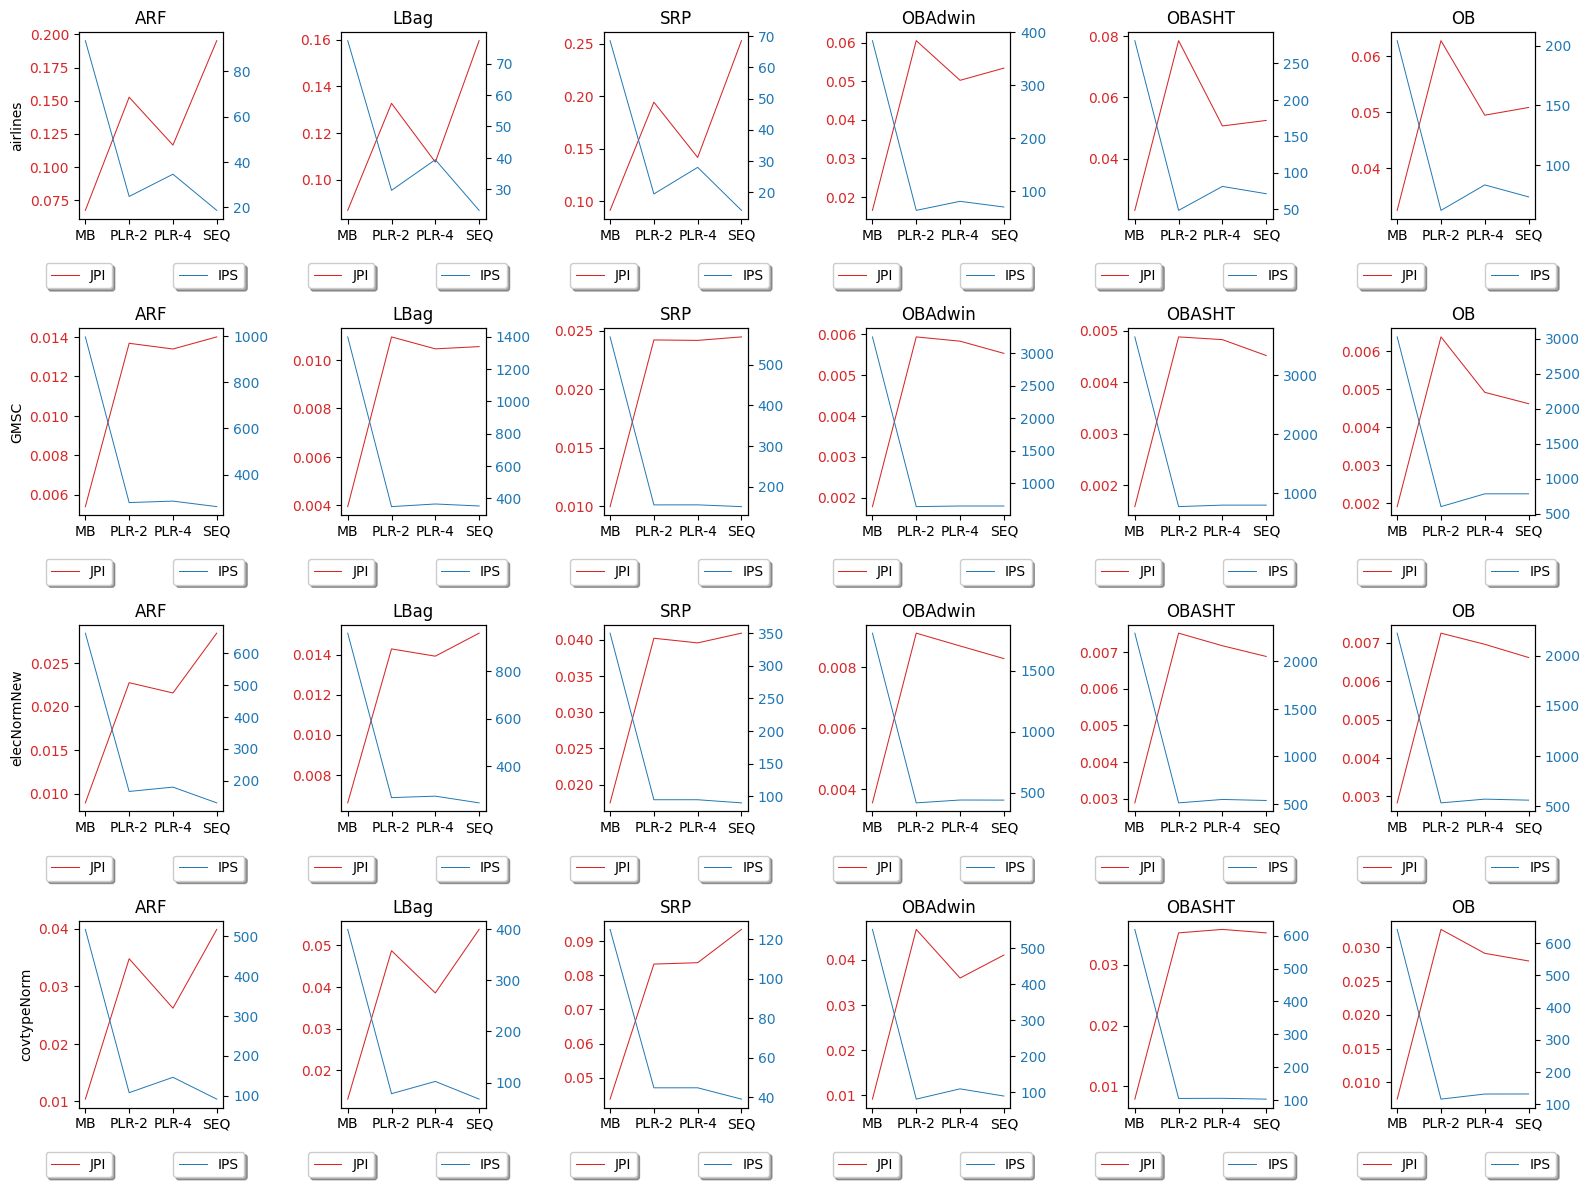

In [52]:
df = dataframes_minimum_freq_mb
print(f'\n\n\n----------------- {f} -----------------')
df = df[df.PERC == '90']
df = df.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'cores']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']
df = build_label(df)
df = df.drop_duplicates().sort_values(by=['label'], ascending=True)
gen_graph_joules(df)

Beforehand, it is necessary to analyse in detail the for minimum frequency. The figure X show in details JPI consumer by execution and IPS are 24 executions with 4 datasets diffentes and four methods differents. In MB are executions with mini-batching, PLR-2 and PLR-4 are executions parallels with respective cores and finally, SEQ represent sequential execution, in other words, original MOA implementation.

A trend can be observed with all experiments. First execution MB had low consumer JPI and high consumer IPS and then JPI is increased with 2 cores and decrease 4 cores, after increased again in SEQ, while IPS trend a decrease. But is visible the experiments parallel with minimum frequency is better result in JPI and IPS that original implementation SEQ.

Is necessary, we also see the results to maximum frequency. In figure Y we can see this data, firstly same similar trend with JPI and IPS. Increase JPI when used PLR-2 and PLR-4, after more JPI in sequential and IPS decrease in all experiments. The main change is values absolutes, for example, in first execution ARF with dataset Airlines in figure X maximum JPI is 0.200 while in figure Y 0.12, and PLR-2 and PLR-4




----------------- {'minimum': '1200', 'maximum': '1200', 'cores': 4} -----------------


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
339,airlines,ARF,50,65.95,"11,250.00",120.20,0.07,4,93.59,MB
105,airlines,ARFRUNPER,1,66.98,"5,760.00",120.00,0.10,2,48.00,PLR-2
249,airlines,ARFRUNPER,1,65.97,"6,644.00",120.00,0.09,4,55.37,PLR-4
102,airlines,ARFSequential,1,68.64,"4,299.00",120.01,0.12,1,35.82,SEQ
246,airlines,ARFSequential,1,68.46,"4,435.00",120.01,0.12,1,36.95,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
336,airlines,LBag,50,61.81,"9,300.00",120.34,0.09,4,77.28,MB
99,airlines,LBagRUNPER,1,64.43,"5,892.00",120.01,0.10,2,49.10,PLR-2
243,airlines,LBagRUNPER,1,63.06,"7,141.00",120.00,0.09,4,59.51,PLR-4
96,airlines,LBagSequential,1,67.35,"4,217.00",120.05,0.13,1,35.13,SEQ
240,airlines,LBagSequential,1,66.97,"4,344.00",120.08,0.12,1,36.17,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
324,airlines,SRPSequential,50,65.52,"8,250.00",120.27,0.09,4,68.60,MB
72,airlines,SRPRUNPER,1,68.60,"4,739.00",120.00,0.12,2,39.49,PLR-2
216,airlines,SRPRUNPER,1,66.78,"6,270.00",120.01,0.10,4,52.25,PLR-4
75,airlines,SRPSequential,1,72.01,"3,097.00",120.02,0.17,1,25.80,SEQ
219,airlines,SRPSequential,1,71.84,"3,214.00",120.00,0.16,1,26.78,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
330,airlines,OBAdwinSequential,50,68.65,"46,150.00",120.06,0.02,4,384.40,MB
81,airlines,OBAdwinRUNPER,1,63.86,"13,422.00",120.01,0.04,2,111.84,PLR-2
225,airlines,OBAdwinRUNPER,1,63.28,"17,307.00",120.03,0.04,4,144.19,PLR-4
84,airlines,OBAdwinSequential,1,63.51,"14,355.00",120.02,0.04,1,119.60,SEQ
228,airlines,OBAdwinSequential,1,63.41,"15,116.00",120.01,0.04,1,125.96,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
333,airlines,OBASHTSequential,50,67.76,"34,300.00",121.91,0.02,4,281.36,MB
87,airlines,OBASHTRUNPER,1,62.88,"13,335.00",120.00,0.04,2,111.12,PLR-2
231,airlines,OBASHTRUNPER,1,62.77,"16,674.00",120.00,0.04,4,138.94,PLR-4
90,airlines,OBASHTSequential,1,64.72,"8,699.00",120.36,0.06,1,72.27,SEQ
234,airlines,OBASHTSequential,1,63.87,"14,770.00",120.00,0.04,1,123.08,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
327,airlines,OBSequential,50,66.19,"24,700.00",120.98,0.03,4,204.16,MB
78,airlines,OBRUNPER,1,65.00,"13,790.00",120.00,0.04,2,114.91,PLR-2
222,airlines,OBRUNPER,1,61.68,"16,656.00",120.62,0.04,4,138.08,PLR-4
93,airlines,OBSequential,1,66.32,"14,462.00",120.00,0.04,1,120.52,SEQ
237,airlines,OBSequential,1,64.75,"13,000.00",120.00,0.04,1,108.33,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
357,GMSC,ARF,50,93.53,"119,600.00",119.96,0.01,4,996.97,MB
141,GMSC,ARFRUNPER,1,93.45,"69,123.00",120.00,0.01,2,576.02,PLR-2
285,GMSC,ARFRUNPER,1,93.44,"74,744.00",120.00,0.01,4,622.85,PLR-4
282,GMSC,ARFSequential,1,93.41,"60,885.00",120.00,0.01,1,507.37,SEQ
138,GMSC,ARFSequential,1,93.44,"61,436.00",120.00,0.01,1,511.95,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
354,GMSC,LBag,50,93.34,"150,000.00",107.18,0.00,4,"1,399.55",MB
135,GMSC,LBagRUNPER,1,93.50,"85,387.00",120.42,0.01,2,709.09,PLR-2
279,GMSC,LBagRUNPER,1,93.50,"96,785.00",120.00,0.01,4,806.53,PLR-4
276,GMSC,LBagSequential,1,93.48,"84,386.00",120.00,0.01,1,703.21,SEQ
132,GMSC,LBagSequential,1,93.48,"81,375.00",120.00,0.01,1,678.12,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
342,GMSC,SRPSequential,50,93.43,"68,250.00",120.03,0.01,4,568.60,MB
108,GMSC,SRPRUNPER,1,93.51,"35,936.00",120.00,0.02,2,299.46,PLR-2
252,GMSC,SRPRUNPER,1,93.51,"35,938.00",120.00,0.01,4,299.48,PLR-4
255,GMSC,SRPSequential,1,93.51,"35,679.00",120.01,0.01,1,297.31,SEQ
111,GMSC,SRPSequential,1,93.54,"34,756.00",120.00,0.02,1,289.63,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
348,GMSC,OBAdwinSequential,50,93.33,"149,259.00",45.95,0.00,4,"3,248.01",MB
117,GMSC,OBAdwinRUNPER,1,93.52,"146,124.00",113.01,0.00,2,"1,293.06",PLR-2
261,GMSC,OBAdwinRUNPER,1,93.52,"149,599.00",95.56,0.00,4,"1,565.55",PLR-4
120,GMSC,OBAdwinSequential,1,93.45,"150,000.00",95.53,0.00,1,"1,570.27",SEQ
264,GMSC,OBAdwinSequential,1,93.45,"150,000.00",95.52,0.00,1,"1,570.34",SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
351,GMSC,OBASHTSequential,50,93.36,"150,000.00",41.10,0.00,4,"3,649.90",MB
123,GMSC,OBASHTRUNPER,1,93.38,"145,344.00",91.82,0.00,2,"1,582.91",PLR-2
267,GMSC,OBASHTRUNPER,1,93.41,"149,486.00",87.21,0.00,4,"1,714.03",PLR-4
270,GMSC,OBASHTSequential,1,93.33,"150,000.00",87.14,0.00,1,"1,721.31",SEQ
126,GMSC,OBASHTSequential,1,93.37,"149,484.00",87.17,0.00,1,"1,714.78",SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
345,GMSC,OBSequential,50,93.39,"149,625.00",49.43,0.00,4,"3,027.19",MB
114,GMSC,OBRUNPER,1,93.54,"146,719.00",115.21,0.00,2,"1,273.49",PLR-2
258,GMSC,OBRUNPER,1,93.56,"149,673.00",90.65,0.00,4,"1,651.11",PLR-4
273,GMSC,OBSequential,1,93.45,"150,000.00",90.55,0.00,1,"1,656.49",SEQ
129,GMSC,OBSequential,1,93.45,"150,000.00",90.54,0.00,1,"1,656.78",SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
303,elecNormNew,ARF,50,80.72,"43,654.00",65.86,0.01,4,662.88,MB
33,elecNormNew,ARFRUNPER,1,88.59,"43,873.00",120.00,0.01,2,365.60,PLR-2
177,elecNormNew,ARFRUNPER,1,88.77,"45,312.00",114.99,0.01,4,394.05,PLR-4
30,elecNormNew,ARFSequential,1,88.76,"35,114.00",120.00,0.01,1,292.61,SEQ
174,elecNormNew,ARFSequential,1,88.56,"36,321.00",120.00,0.01,1,302.67,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
300,elecNormNew,LBag,50,81.39,"42,962.00",44.80,0.01,4,958.91,MB
27,elecNormNew,LBagRUNPER,1,89.83,"43,680.00",79.87,0.01,2,546.92,PLR-2
171,elecNormNew,LBagRUNPER,1,89.96,"44,761.00",73.27,0.01,4,610.89,PLR-4
24,elecNormNew,LBagSequential,1,89.78,"42,652.00",91.92,0.01,1,464.01,SEQ
168,elecNormNew,LBagSequential,1,89.78,"44,200.00",86.10,0.01,1,513.36,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
288,elecNormNew,SRPSequential,50,80.95,"41,930.00",119.95,0.02,4,349.55,MB
0,elecNormNew,SRPRUNPER,1,90.66,"23,395.00",120.00,0.02,2,194.95,PLR-2
144,elecNormNew,SRPRUNPER,1,90.27,"26,955.00",119.97,0.02,4,224.68,PLR-4
3,elecNormNew,SRPSequential,1,91.51,"20,033.00",120.01,0.03,1,166.93,SEQ
147,elecNormNew,SRPSequential,1,91.33,"20,695.00",120.00,0.03,1,172.46,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
294,elecNormNew,OBAdwinSequential,50,79.48,"42,484.00",23.52,0.00,4,"1,806.45",MB
9,elecNormNew,OBAdwinRUNPER,1,86.11,"42,041.00",49.81,0.01,2,844.06,PLR-2
153,elecNormNew,OBAdwinRUNPER,1,86.37,"44,255.00",43.91,0.01,4,"1,007.79",PLR-4
12,elecNormNew,OBAdwinSequential,1,84.64,"43,948.00",43.91,0.00,1,"1,000.77",SEQ
156,elecNormNew,OBAdwinSequential,1,84.45,"45,068.00",43.92,0.00,1,"1,026.14",SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
297,elecNormNew,OBASHTSequential,50,79.37,"43,758.00",19.06,0.00,4,"2,295.92",MB
15,elecNormNew,OBASHTRUNPER,1,83.99,"41,021.00",39.06,0.00,2,"1,050.23",PLR-2
159,elecNormNew,OBASHTRUNPER,1,84.05,"44,185.00",37.60,0.00,4,"1,175.07",PLR-4
18,elecNormNew,OBASHTSequential,1,83.16,"42,930.00",37.54,0.00,1,"1,143.67",SEQ
162,elecNormNew,OBASHTSequential,1,83.28,"44,672.00",37.55,0.00,1,"1,189.54",SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
291,elecNormNew,OBSequential,50,78.67,"43,510.00",19.58,0.00,4,"2,222.73",MB
6,elecNormNew,OBRUNPER,1,82.47,"40,776.00",38.41,0.00,2,"1,061.52",PLR-2
150,elecNormNew,OBRUNPER,1,83.01,"43,639.00",36.42,0.00,4,"1,198.35",PLR-4
21,elecNormNew,OBSequential,1,82.94,"43,645.00",36.40,0.00,1,"1,198.97",SEQ
165,elecNormNew,OBSequential,1,81.67,"44,432.00",36.39,0.00,1,"1,220.99",SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
321,covtypeNorm,ARF,50,86.23,"62,100.00",120.05,0.01,4,517.28,MB
69,covtypeNorm,ARFRUNPER,1,84.01,"34,302.00",120.00,0.02,2,285.85,PLR-2
213,covtypeNorm,ARFRUNPER,1,85.94,"42,105.00",120.00,0.01,4,350.87,PLR-4
66,covtypeNorm,ARFSequential,1,83.83,"33,842.00",120.00,0.02,1,282.01,SEQ
210,covtypeNorm,ARFSequential,1,81.49,"26,671.00",120.00,0.02,1,222.25,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
318,covtypeNorm,LBag,50,85.43,"47,900.00",120.02,0.01,4,399.11,MB
63,covtypeNorm,LBagRUNPER,1,78.61,"21,051.00",120.00,0.03,2,175.42,PLR-2
207,covtypeNorm,LBagRUNPER,1,83.31,"31,128.00",120.00,0.02,4,259.40,PLR-4
60,covtypeNorm,LBagSequential,1,74.35,"14,672.00",120.00,0.04,1,122.26,SEQ
204,covtypeNorm,LBagSequential,1,74.07,"15,424.00",120.01,0.03,1,128.53,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
306,covtypeNorm,SRPSequential,50,75.44,"14,975.00",119.94,0.04,4,124.85,MB
36,covtypeNorm,SRPRUNPER,1,81.81,"10,333.00",120.01,0.05,2,86.10,PLR-2
180,covtypeNorm,SRPRUNPER,1,81.42,"12,435.00",120.00,0.05,4,103.62,PLR-4
39,covtypeNorm,SRPSequential,1,82.03,"8,357.00",120.03,0.06,1,69.62,SEQ
183,covtypeNorm,SRPSequential,1,82.06,"8,934.00",120.00,0.06,1,74.45,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
312,covtypeNorm,OBAdwinSequential,50,83.41,"66,150.00",120.01,0.01,4,551.19,MB
45,covtypeNorm,OBAdwinRUNPER,1,80.07,"23,720.00",120.00,0.02,2,197.67,PLR-2
189,covtypeNorm,OBAdwinRUNPER,1,81.04,"37,362.00",120.00,0.02,4,311.35,PLR-4
48,covtypeNorm,OBAdwinSequential,1,78.27,"25,711.00",120.00,0.02,1,214.25,SEQ
192,covtypeNorm,OBAdwinSequential,1,76.82,"23,513.00",120.00,0.02,1,195.94,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
315,covtypeNorm,OBASHTSequential,50,81.67,"74,350.00",120.01,0.01,4,619.54,MB
51,covtypeNorm,OBASHTRUNPER,1,75.91,"32,650.00",120.00,0.02,2,272.08,PLR-2
195,covtypeNorm,OBASHTRUNPER,1,75.81,"36,904.00",120.00,0.01,4,307.53,PLR-4
54,covtypeNorm,OBASHTSequential,1,72.21,"26,399.00",120.00,0.02,1,219.99,SEQ
198,covtypeNorm,OBASHTSequential,1,71.07,"23,342.00",120.00,0.02,1,194.52,SEQ


,dataset,algorithm,batch_size,acc,instances,time,JPI,cores,IPS,label
309,covtypeNorm,OBSequential,50,81.89,"77,200.00",120.03,0.01,4,643.20,MB
42,covtypeNorm,OBRUNPER,1,75.12,"31,484.00",120.00,0.02,2,262.36,PLR-2
186,covtypeNorm,OBRUNPER,1,75.04,"36,178.00",120.00,0.02,4,301.48,PLR-4
57,covtypeNorm,OBSequential,1,73.96,"34,000.00",120.00,0.01,1,283.33,SEQ
201,covtypeNorm,OBSequential,1,73.15,"32,605.00",120.00,0.02,1,271.70,SEQ


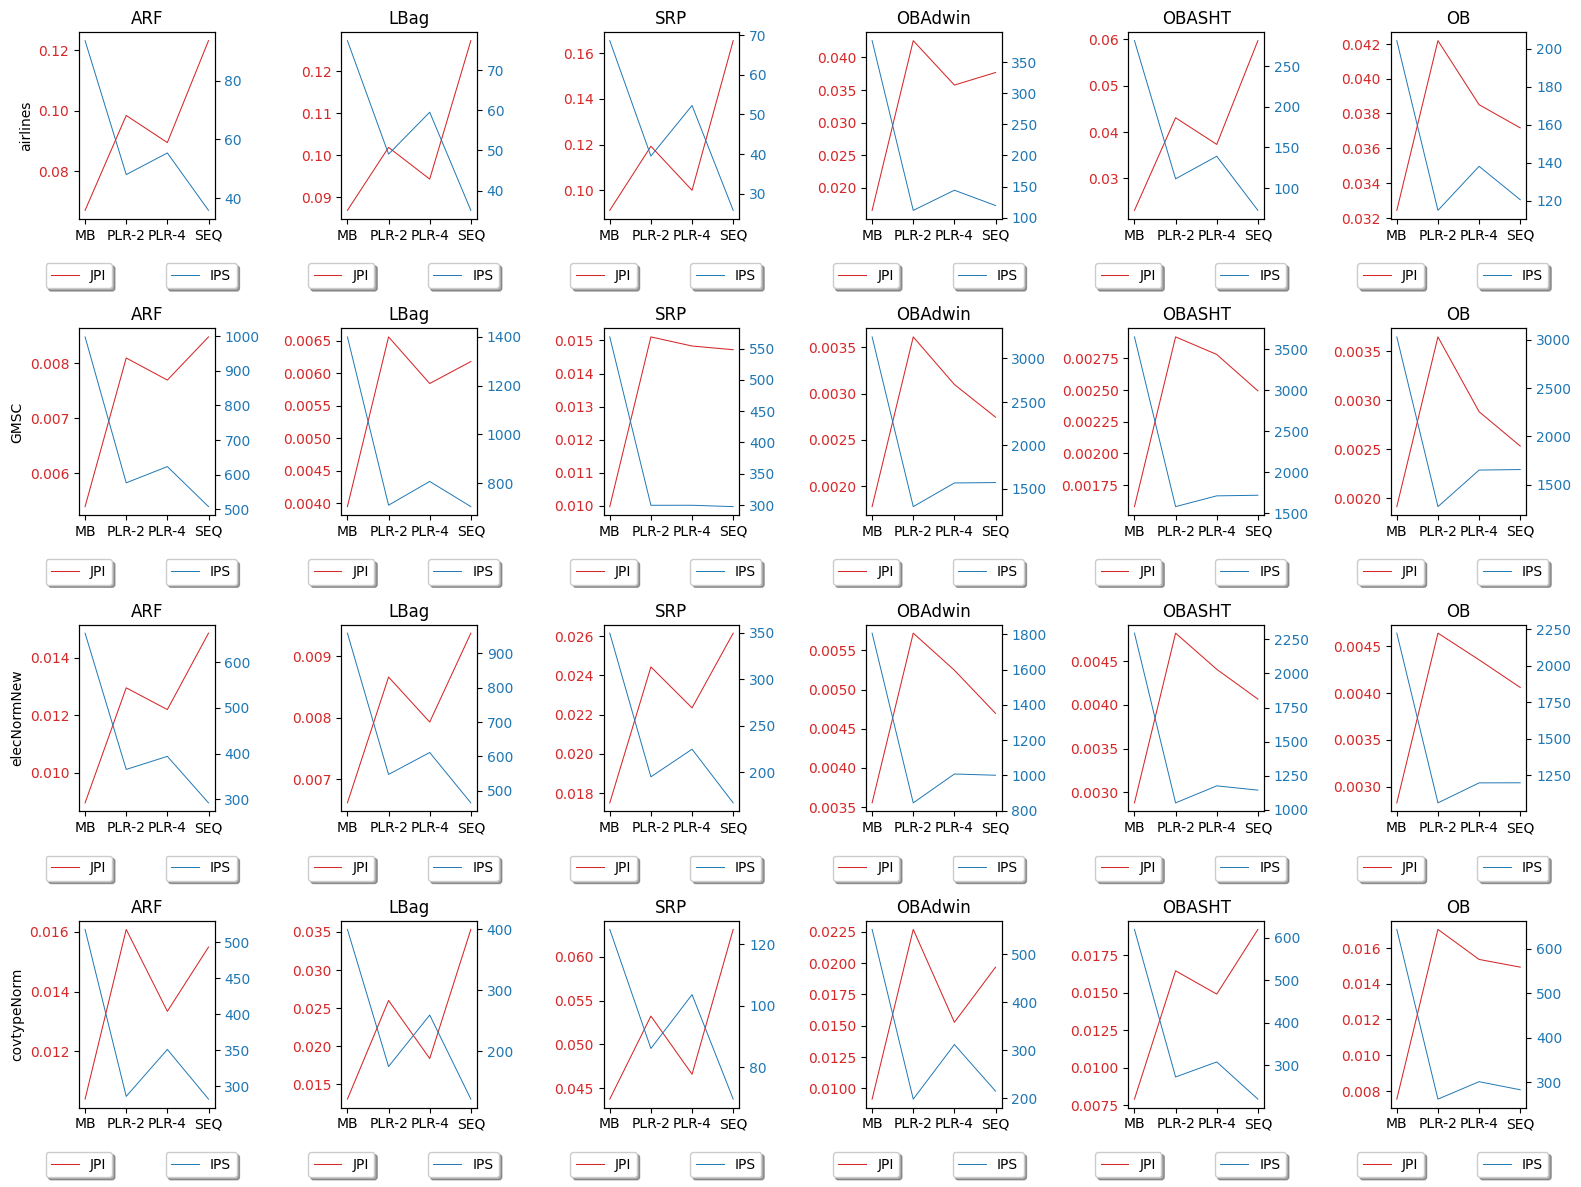

In [53]:
df = dataframes_maximum_freq_mb
print(f'\n\n\n----------------- {f} -----------------')
df = df[df.PERC == '90']
df = df.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'cores']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']
df = build_label(df)
df = df.drop_duplicates().sort_values(by=['label'], ascending=True)
gen_graph_joules(df)